# American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This excercise focuses on classifying a subset of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters A-I, we want to detect which letter is being represented.

![](https://drive.google.com/uc?export=view&id=1C8r-cwHSbpK2bD4n-00XzKhwuPN1ZOQv)

## Data Loading
The data for this excercise is present in "[asl_data.zip](https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0)". The dataset contains 9 classes (images corresponding to characters A to I). For convenience, the dataset is structured in such a way that we can use TorchVision's ImageFolder dataset [(documentation)](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) rather than writing your own custom dataset loader.

In [ ]:
# Define the standard imports
from __future__ import print_function 
from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy

## Data loader

In [ ]:
# Download the data in the current working directory
!rm -rf asl_data.zip asl_data
!wget -O asl_data.zip https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
!unzip asl_data.zip
!rm asl_data.zip

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./asl_data"

# Define the class label
class_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I'}

--2020-11-17 07:28:54--  https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r75maq5e1vyda4g/asl_data.zip [following]
--2020-11-17 07:28:55--  https://www.dropbox.com/s/raw/r75maq5e1vyda4g/asl_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0116f75c02d8707b50d5756cd5.dl.dropboxusercontent.com/cd/0/inline/BDUL3RWBVeYyxa-_ycJFLXJcOFv-4A8e5nRDM4YexGfxt0i5l3udsttPVScNwuh0b3cl_JzUmw_NBH0x9EMXycitvn8bW-Uos1wjVQTwwC4EI9AIRFmbP1J9DRcfPAVd-6M/file# [following]
--2020-11-17 07:28:55--  https://uc0116f75c02d8707b50d5756cd5.dl.dropboxusercontent.com/cd/0/inline/BDUL3RWBVeYyxa-_ycJFLXJcOFv-4A8e5nRDM4YexGfxt0i5l3udsttPVScNwuh0b3cl_JzUmw_NBH0x9EMXycitvn8bW-Uos1wjVQTwwC4EI

## Visualize the data

We will now see how the sample data looks like

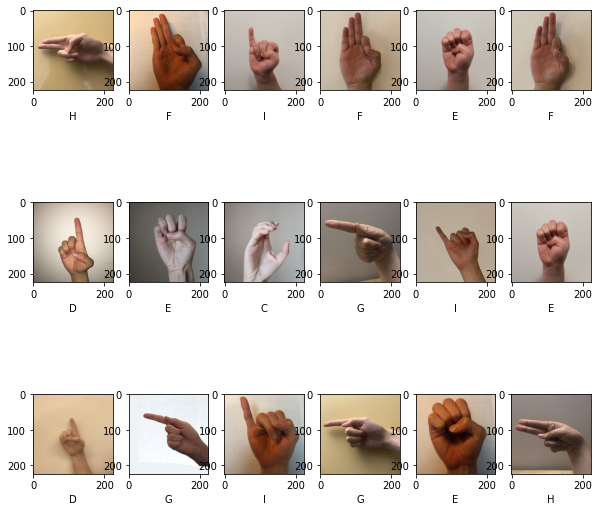

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms.ToTensor()) for x in ['train', 'val']}
val_dataloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=True)
train_dataloader=torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=True)
f = plt.figure(figsize=(10, 10))
for i in range(18):
    img, label = next(iter(val_dataloader))
    img = img.squeeze().permute(1,2,0).numpy()
    plt.subplot(3,6,i+1)
    plt.imshow(img)
    plt.xlabel(class_dict[label.numpy()[0]])


# Excercise: Neural Network

In this excercise you will be using a neural network. You are free to use one of the pretrained model, as demonstrated in the previous lab, or write your own neural network from scratch.

You may use the PyTorch documentation, previous excercises and notebooks freely. You might find documentations and notebooks discussed in the last two classes helpful. However, all code and analysis that you submit must be your own.


### **Questions**
**Question 1: Model Building**

Build a multi-layered perceptron (MLP) in Pytorch that inputs  that takes the (224x224 RGB) image as input, and predicts the letter (You may need to flatten the image vector first). Your model should be a subclass of `nn.Module`. Explain your choice of neural network architecture: how many layers your network has? What types of layers does it contain? What about other decisions like use of dropout layers, activation functions, number of channels / hidden units.

**Question 2: Training Code** 

Write code to train your neural network given some training data. Your training code should make it easy to tweak hyperparameters. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function. Ensure that your code runs on GPU.


**Question 3: Overfit to a Small Dataset** 

**Part (a)**: One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting a small dataset. Construct a small dataset (e.g. 1-2 image per class). Then show that your model and training code is capable of overfitting on that small dataset. You should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

If your model cannot overfit the small dataset quickly, then there is a bug in either your model code and/or your training code. Fix the issues before you proceed to the next step.

**Part (b)**: Once you are done with the above part, try to reduce the effect of overfitting by using techniques discussed in the previous lecture.

**Question 4: Finetuning** 

For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

In this part, you will use Transfer Learning to extract features from the hand gesture images. Then, train last few classification layers to use these features as input and classify the hand gestures. As you have learned in the previous lecture, you can use AlexNet architecture that is pretrained on 1000-class ImageNet dataset and finetune it for the task of understanding American sign language.

**Question 5: Report result** 

Train your new network, including any hyperparameter tuning. Plot and submit the training and validation loss and accuracy of your best model only. Along with it, also submit the final validation accuracy achieved by your model.


# Question 1: Model Building

Build a multi-layered perceptron (MLP) in Pytorch that inputs that takes the (224x224 RGB) image as input, and predicts the letter (You may need to flatten the image vector first). Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how many layers your network has? What types of layers does it contain? What about other decisions like use of dropout layers, activation functions, number of channels / hidden units.

In [ ]:
c1 = 6 ; k1 = 5 
#l1 = (c1 * ((224 - k1 + 1) ** 2)) // 100
c2 = 12 ; k2 = 5
l1 = 128
l2 = 64
l3 = 32

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, c1, k1, bias = False)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(c1, c2, k2, bias = False)
        #self.pool
        # Initialize all the layers with learnable parameters
        self.layer1 = nn.Linear(c2 * ((224 - k1 - k2 + 1 + 1) ** 2), l1, bias = False)
        self.layer2 = nn.Linear(l1, l2, bias = False)
        self.layer3 = nn.Linear(l2, l3, bias =  False)
        self.out = nn.Linear(l3, 9, bias = False)

    def forward(self, img):
        #print(img.shape)
        img = F.relu(self.conv1(img))
        #print(img.shape)
        img = F.relu(self.conv2(img))
        img = img.view(-1, (c2 * ((224 - k2 - k1 + 1 + 1) ** 2)))
        img = F.relu(self.layer1(img))
        img = F.relu(self.layer2(img))
        img = F.relu(self.layer3(img))
        img = self.out(img)
        return img

model = Net()


In [ ]:
#i = trainval(model, mnist_data, mnist_test, 'cpu', num_iters=2000)

In [ ]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data = torch.rand(m.weight.data.shape)

weights_init(model)
len(list(model.parameters()))

6

# Question 2: Training Code

Write code to train your neural network given some training data. Your training code should make it easy to tweak hyperparameters. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function. Ensure that your code runs on GPU.

In [ ]:
def trainval(model, train_data, valid_data, device, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay = 0):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, weight_decay = weight_decay)

    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    for n in range(num_iters):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            #return imgs
            #print(imgs.shape)

            model.train() #*****************************#
            optimizer.zero_grad()         # a clean up step for PyTorch
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # Data collection for the graphs
            if n % 10 == 9:
                #print('y',end='')
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_accuracy = get_accuracy(model, train_data, device)
                val_accuracy = get_accuracy(model, valid_data, device)
                for im, lb in val_loader:
                    im, lb = im.to(device), lb.to(device)
                    val_out = model(im)
                    val_loss = criterion(val_out, lb)
                val_losses.append(float(val_loss)/batch_size)
                train_acc.append(train_accuracy) # compute training accuracy 
                val_acc.append(val_accuracy)   # compute validation accuracy
            if n%100 == 99:
              print(n, end = " ")
    print()
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve:Loss")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    #plt.ylim((0,1.1))

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.ylim((0,1.1))
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


def get_accuracy(model, data, device):
    correct = 0
    total = 0

    model.eval() #Model in the evaluation mode
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        # print("Pred:", pred,"\nLabels:", labels)
        total += imgs.shape[0]
        accuracy = correct / total
    return accuracy

# Question 3: Overfit to a Small Dataset

## Part a: 

One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting a small dataset. Construct a small dataset (e.g. 1-2 image per class). Then show that your model and training code is capable of overfitting on that small dataset. You should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

If your model cannot overfit the small dataset quickly, then there is a bug in either your model code and/or your training code. Fix the issues before you proceed to the next step.

In [ ]:
mnist_data = list(image_datasets['train'])
mnist_test = list(image_datasets['val'])

In [ ]:
cur=0
myDict = {}
for i in range(9):
  myDict[i] = 0
#print(myDict)
for i in range(len(mnist_data)):
  label = mnist_data[i][1]
  if(label!=cur):
    #print(label,":",i, end="\n")
    myDict[label]=i
    cur=label
  myDict[label]+=1
print(myDict)

{0: 108, 1: 215, 2: 307, 3: 414, 4: 506, 5: 612, 6: 714, 7: 818, 8: 931}


In [ ]:
import random
random.seed(0)
# random.shuffle(mnist_data)
# random.shuffle(mnist_test)
num_train = 2
num_val = 10
mnist_train = []
mnist_val = []
print(type(mnist_train))

for i in range(9):
  mnist_train += mnist_data[myDict[i] - myDict[max(0,i-1)] :myDict[i] + num_train - myDict[max(0,i-1)]]
  mnist_val += mnist_data[myDict[i] + num_train - myDict[max(0,i-1)]:myDict[i] + num_val + num_train - myDict[max(0,i-1)]]

random.shuffle(mnist_train)
random.shuffle(mnist_val)

print('Number of training images: {}'.format(len(mnist_train)))
print('Number of validation images: {}'.format(len(mnist_val)))
# print('Number of test images: {}'.format(len(mnist_test_data)))

<class 'list'>
Number of training images: 18
Number of validation images: 90


99 199 299 399 499 599 699 799 899 999 


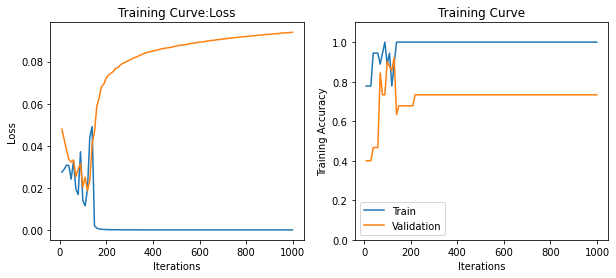

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7333333333333333


In [ ]:
model = Net()

# Ship data and model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

trainval(model, mnist_train, mnist_val, device, num_iters=1000)

## Part b
Once you are done with the above part, try to reduce the effect of overfitting by using techniques discussed in the previous lecture.

In [ ]:
c1 = 6 ; k1 = 5 
c2 = 12 ; k2 = 5 
l1 = 128
l2 = 64
l3 = 32
l0 = c2 * ((( (224 - k1+1)//2 - k2 +1 )//2) ** 2)
#print(l0)

class NetLanja(nn.Module):

    def __init__(self):
        super(NetLanja, self).__init__()
        self.conv1 = nn.Conv2d(3, c1, k1, bias = True)
        self.conv2 = nn.Conv2d(c1, c2, k1, bias = True)
        # Initialize all the layers with learnable parameters
        self.layer1 = nn.Linear(l0, l1, bias = True)
        self.layer2 = nn.Linear(l1, l2, bias = True)
        self.layer3 = nn.Linear(l2, l3, bias = True)
        self.out = nn.Linear(l3, 9, bias = True)

        self.dropout = nn.Dropout(0.3) # drop out layer with a dropout percentage of 50
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, img):
        #print(img.shape)
        img = self.pool(F.relu(self.conv1(img)))
        #print(img.shape)
        img = self.pool(F.relu(self.conv2(img)))
        #print(img.shape)
        img = img.view(-1, l0)
        #print(img.shape)
        img = F.relu(self.layer1(self.dropout(img)))
        img = F.relu(self.layer2(self.dropout(img)))
        img = F.relu(self.layer3(self.dropout(img)))
        output = (self.out(img))
        return output

model = NetLanja()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

num_train_new = 1
mnist_train_new = mnist_train
for i in range(9):
  mnist_train_new += mnist_data[myDict[i] - myDict[max(0,i-1)]+num_train+num_val:myDict[i] - myDict[max(0,i-1)]+num_train+num_val+num_train_new ]
random.shuffle(mnist_train_new)

trainval(model, mnist_train_new, mnist_val, device, num_iters=1000,  learn_rate = 0.075, weight_decay=0.01)

99 99 199 199 299 299 399 399 499 499 599 599 699 699 799 799 899 899 

# Question 4: Finetuning

For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

In this part, you will use Transfer Learning to extract features from the hand gesture images. Then, train last few classification layers to use these features as input and classify the hand gestures. As you have learned in the previous lecture, you can use AlexNet architecture that is pretrained on 1000-class ImageNet dataset and finetune it for the task of understanding American sign language.



In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_name = "alexnet"
num_classes = 9
feature_extract = True
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=4) for x in ['train', 'val']}
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.5072 Acc: 0.4382
val Loss: 1.1035 Acc: 0.5388

Epoch 1/19
----------
train Loss: 0.9026 Acc: 0.6767
val Loss: 0.6823 Acc: 0.7586

Epoch 2/19
----------
train Loss: 0.7568 Acc: 0.7164
val Loss: 0.8340 Acc: 0.6595

Epoch 3/19
----------
train Loss: 0.6366 Acc: 0.7573
val Loss: 0.6320 Acc: 0.7888

Epoch 4/19
----------
train Loss: 0.6224 Acc: 0.7626
val Loss: 0.7138 Acc: 0.7371

Epoch 5/19
----------
train Loss: 0.5796 Acc: 0.7927
val Loss: 0.6771 Acc: 0.7198

Epoch 6/19
----------
train Loss: 0.5549 Acc: 0.7959
val Loss: 0.6485 Acc: 0.7155

Epoch 7/19
----------
train Loss: 0.5195 Acc: 0.8153
val Loss: 0.7844 Acc: 0.7414

Epoch 8/19
----------
train Loss: 0.4873 Acc: 0.8206
val Loss: 0.5295 Acc: 0.7931

Epoch 9/19
----------
train Loss: 0.4753 Acc: 0.8195
val Loss: 0.5961 Acc: 0.7586

Epoch 10/19
----------
train Loss: 0.5000 Acc: 0.8153
val Loss: 0.5253 Acc: 0.7672

Epoch 11/19
----------
train Loss: 0.4587 Acc: 0.8378
val Loss: 0.5562 Acc: 0.7845

Ep

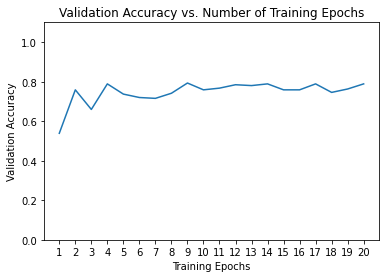

In [ ]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,21),hist)
plt.ylim((0,1.1))
plt.xticks(np.arange(1, 21, 1.0))
#plt.legend()
plt.show()

# Question 5: Report result

Train your new network, including any hyperparameter tuning. Plot and submit the training and validation loss and accuracy of your best model only. Along with it, also submit the final validation accuracy achieved by your model.

27
99 99 199 199 299 299 399 399 499 499 599 599 699 699 799 799 899 899 999 999 


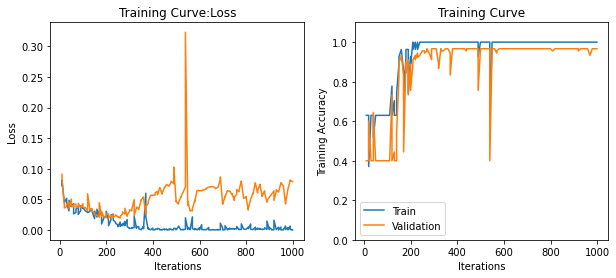

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9666666666666667


In [ ]:
c1 = 6 ; k1 = 5 
c2 = 12 ; k2 = 5 
l1 = 128
l2 = 64
l3 = 32
l0 = c2 * ((( (224 - k1+1)//2 - k2 +1 )//2) ** 2)
#print(l0)

class NetLanja(nn.Module):

    def __init__(self):
        super(NetLanja, self).__init__()
        self.conv1 = nn.Conv2d(3, c1, k1, bias = True)
        self.conv2 = nn.Conv2d(c1, c2, k1, bias = True)
        # Initialize all the layers with learnable parameters
        self.layer1 = nn.Linear(l0, l1, bias = True)
        self.layer2 = nn.Linear(l1, l2, bias = True)
        self.layer3 = nn.Linear(l2, l3, bias = True)
        self.out = nn.Linear(l3, 9, bias = True)

        self.dropout = nn.Dropout(0.5) # drop out layer with a dropout percentage of 50
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, img):
        #print(img.shape)
        img = self.pool(F.relu(self.conv1(img)))
        #print(img.shape)
        img = self.pool(F.relu(self.conv2(img)))
        #print(img.shape)
        img = img.view(-1, l0)
        #print(img.shape)
        img = F.relu(self.layer1(self.dropout(img)))
        img = F.relu(self.layer2(self.dropout(img)))
        img = F.relu(self.layer3(self.dropout(img)))
        output = (self.out(img))
        return output

model = NetLanja()
model.to(device)

num_train_new = 1
mnist_train_new = mnist_train
for i in range(9):
  mnist_train_new += mnist_data[myDict[i] - myDict[max(0,i-1)]+num_train+num_val:myDict[i] - myDict[max(0,i-1)]+num_train+num_val+num_train_new ]
random.shuffle(mnist_train_new)
print(len(mnist_train_new))
exit()

trainval(model, mnist_train_new, mnist_val, device, num_iters=1000,  weight_decay=0.01)